In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('D:\Hackathon\gajsheild final\malware\Dataset\dataset_malwares.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<>:12: SyntaxWarning: invalid escape sequence '\H'
<>:12: SyntaxWarning: invalid escape sequence '\H'
C:\Users\damod\AppData\Local\Temp\ipykernel_22376\3196695322.py:12: SyntaxWarning: invalid escape sequence '\H'
  for dirname, _, filenames in os.walk('D:\Hackathon\gajsheild final\malware\Dataset\dataset_malwares.csv'):


In [2]:
!pip install pefile 

In [3]:
# -*- coding: utf-8 -*-
"""
Block 1: Installations, Imports & Setup
Installs necessary packages (uncomment if needed), imports libraries,
and configures settings.
"""

# === Installations (Uncomment if needed in Kaggle) ===
print("Installing required packages...")
# Using --quiet to reduce installation noise
!pip install xgboost --quiet
!pip install lightgbm --quiet
!pip install shap --quiet
!pip install pefile --quiet # We are avoiding direct dependency in training
!pip install joblib --quiet # Usually pre-installed
print("Installations attempted (Ensure XGBoost, LightGBM, SHAP are installed if used).")

# === Core Libraries ===
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import os
import json
import math
import time
import warnings

# === Scikit-learn ===
from sklearn.model_selection import (
    train_test_split, learning_curve, cross_val_score,
    GridSearchCV, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.impute import SimpleImputer

# === Gradient Boosting Libraries ===
try:
    import xgboost as xgb
    xgb_available = True
except ImportError:
    xgb_available = False
    print("Warning: XGBoost not found. XGBoost models will be skipped.")

try:
    import lightgbm as lgb
    lgb_available = True
except ImportError:
    lgb_available = False
    print("Warning: LightGBM not found. LightGBM models will be skipped.")

# === Explainability Library ===
try:
    import shap
    shap.initjs() # Initialize Javascript for SHAP plots in notebooks
    shap_available = True
except ImportError:
    shap_available = False
    print("Warning: SHAP not found. SHAP plots will be skipped.")

# === Configuration ===
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.set_option('display.max_columns', None)

# --- Kaggle Path Setup ---
kaggle_input_dir = '/kaggle/input/pe-files-malwares'
kaggle_output_dir = '/kaggle/working/'
dataset_path = os.path.join(kaggle_input_dir, 'dataset_malwares.csv')
test_dataset_path = os.path.join(kaggle_input_dir, 'dataset_test.csv') # Added test dataset path
model_output_dir = os.path.join(kaggle_output_dir, 'ML_model_final')
os.makedirs(model_output_dir, exist_ok=True)

print(f"\nLibraries imported successfully.")
print(f"Kaggle Input Directory: {kaggle_input_dir}")
print(f"Kaggle Output Directory: {kaggle_output_dir}")
print(f"Expected Training Dataset Path: {dataset_path}")
print(f"Expected Test Dataset Path: {test_dataset_path}") # Print test dataset path
print(f"Model Output Directory: {model_output_dir}")

# --- Placeholder for pefile check ---
# We won't use pefile directly for training, but check if it *could* be imported
# for the final prediction function's context.
try:
    import pefile
    pefile_available = True
    print("Note: 'pefile' library is available (needed for predicting NEW raw files).")
except ImportError:
    pefile_available = False
    print("Note: 'pefile' library is NOT available. Feature extraction for NEW raw files will not work.")

Installing required packages...


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Installations attempted (Ensure XGBoost, LightGBM, SHAP are installed if used).



Libraries imported successfully.
Kaggle Input Directory: /kaggle/input/pe-files-malwares
Kaggle Output Directory: /kaggle/working/
Expected Training Dataset Path: /kaggle/input/pe-files-malwares\dataset_malwares.csv
Expected Test Dataset Path: /kaggle/input/pe-files-malwares\dataset_test.csv
Model Output Directory: /kaggle/working/ML_model_final
Note: 'pefile' library is available (needed for predicting NEW raw files).


In [4]:
# -*- coding: utf-8 -*-
"""
Block 2: Define Plotting Functions
Contains helper functions for visualizing model performance and explanations.
"""
print("\n--- Defining Plotting Functions ---")

# --- Plotting Helper Functions (Copied from previous enhanced version) ---
def plot_classification_metrics(y_true, y_pred, y_scores=None, title_suffix=""):
    """Plot comprehensive classification metrics"""
    print(f"\n--- Generating Classification Metrics {title_suffix} ---")
    try:
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        metrics_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
            'Value': [accuracy, precision, recall, f1]
        })

        plt.figure(figsize=(8, 5)) # Smaller figure size
        ax = sns.barplot(x='Metric', y='Value', data=metrics_df, palette="viridis")
        plt.title(f'Classification Metrics {title_suffix}', fontsize=14)
        plt.ylim(0.9, 1.02) # Focus on high scores
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, xytext=(0, 3), textcoords='offset points')
        plt.tight_layout()
        plt.show()

        print(f"\nClassification Report {title_suffix}:")
        print(classification_report(y_true, y_pred, zero_division=0, target_names=['Benign', 'Malware']))

        if y_scores is not None:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(7, 5)) # Smaller figure size
            roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=title_suffix.strip())
            roc_display.plot(color='darkorange')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.title(f'ROC Curve {title_suffix}')
            plt.grid(alpha=0.3)
            plt.show()

            precision_pr, recall_pr, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = auc(recall_pr, precision_pr)
            plt.figure(figsize=(7, 5)) # Smaller figure size
            pr_display = PrecisionRecallDisplay(precision=precision_pr, recall=recall_pr, average_precision=pr_auc, estimator_name=title_suffix.strip())
            pr_display.plot(color='blue')
            plt.title(f'Precision-Recall Curve {title_suffix}')
            plt.grid(alpha=0.3)
            plt.show()
        else:
            print(f"Probability/decision scores not available for ROC/PR curves {title_suffix}.")
    except Exception as e:
        print(f"Error in plot_classification_metrics: {e}")

def plot_confusion_matrix(y_true, y_pred, classes=['Benign', 'Malware'], title_suffix="", normalize=False):
    """Plot confusion matrix with annotations"""
    print(f"\n--- Generating Confusion Matrix {title_suffix} {'(Normalized)' if normalize else ''} ---")
    try:
        cm = confusion_matrix(y_true, y_pred)
        fmt = '.2%' if normalize else 'd'
        cmap = "Blues"
        title = f'Normalized Confusion Matrix {title_suffix}' if normalize else f'Confusion Matrix {title_suffix}'

        if normalize:
            row_sums = cm.sum(axis=1, keepdims=True)
            cm_normalized = np.zeros_like(cm, dtype=float)
            non_zero_rows = row_sums.flatten() != 0
            # Avoid division by zero
            if np.any(non_zero_rows):
                 cm_normalized[non_zero_rows] = cm[non_zero_rows].astype('float') / row_sums[non_zero_rows]
            cm_to_plot = cm_normalized
        else:
            cm_to_plot = cm

        plt.figure(figsize=(6, 5)) # Smaller figure size
        sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap=cmap,
                    xticklabels=classes, yticklabels=classes, annot_kws={"size": 12})
        plt.title(title, fontsize=14)
        plt.ylabel('True Label', fontsize=11)
        plt.xlabel('Predicted Label', fontsize=11)
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9, rotation=0)
        plt.tight_layout()
        plt.show()

        if not normalize and np.sum(cm) > 0: # Ensure total is not zero for breakdown
             tn, fp, fn, tp = cm.ravel()
             total = np.sum(cm)
             print(f"\nConfusion Matrix Breakdown:")
             print(f"  True Negatives (TN): {tn} ({tn/total:.2%})")
             print(f"  False Positives (FP): {fp} ({fp/total:.2%})")
             print(f"  False Negatives (FN): {fn} ({fn/total:.2%})")
             print(f"  True Positives (TP): {tp} ({tp/total:.2%})")
        elif not normalize:
             print("\nCannot calculate Confusion Matrix Breakdown: No samples.")
    except Exception as e:
        print(f"Error in plot_confusion_matrix: {e}")

def plot_feature_importance(clf, feature_names, top_n=30):
    """Plot feature importance for the model if available"""
    print("\n--- Generating Feature Importance ---")
    if not hasattr(clf, 'feature_importances_'):
        print("Model does not have 'feature_importances_'. Skipping plot.")
        return None
    try:
        importances = clf.feature_importances_
        if feature_names is None or len(feature_names) != len(importances):
             feature_names = [f'Feature_{i}' for i in range(len(importances))]
             print("Warning: Using generic feature names.")

        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False)
        top_features = importance_df.head(top_n)

        plt.figure(figsize=(9, max(6, top_n * 0.3))) # Adjust size
        sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis_r')
        plt.title(f'Top {min(top_n, len(feature_names))} Feature Importance', fontsize=14)
        plt.xlabel('Importance Score', fontsize=11)
        plt.ylabel('Feature Name', fontsize=11)
        plt.tight_layout()
        plt.show()
        return importance_df
    except Exception as e:
        print(f"Error in plot_feature_importance: {e}")
        return None

def plot_cross_validation(clf, X, y, cv=5, scoring='accuracy', title_suffix=""):
    """Perform and plot cross-validation results"""
    print(f"\n--- Performing {cv}-Fold Cross-Validation ({scoring}) {title_suffix} ---")
    try:
        # Ensure X and y are compatible with sklearn (e.g., numpy arrays or pandas DataFrames/Series)
        if not isinstance(X, (np.ndarray, pd.DataFrame)): X = pd.DataFrame(X)
        if not isinstance(y, (np.ndarray, pd.Series)): y = pd.Series(y)

        start_time = time.time()
        # Ensure cv object is correctly initialized if passed as an object
        if not isinstance(cv, int):
             cv_fold_generator = cv
        else:
             cv_fold_generator = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42) # Default to stratified

        cv_scores = cross_val_score(clf, X, y, cv=cv_fold_generator, scoring=scoring, n_jobs=-1)
        duration = time.time() - start_time
        print(f"  CV finished in {duration:.2f} seconds.")
        print(f"  CV Scores ({scoring}): {[f'{s:.4f}' for s in cv_scores]}")
        print(f"  Mean CV Score ({scoring}): {np.mean(cv_scores):.4f}")
        print(f"  Std Dev ({scoring}): {np.std(cv_scores):.4f}")

        plt.figure(figsize=(7, 5)) # Smaller
        n_splits = cv if isinstance(cv, int) else cv.get_n_splits() # Get number of splits
        plt.bar(range(1, n_splits + 1), cv_scores, color='skyblue', label=f'{scoring.capitalize()} per Fold')
        mean_score = np.mean(cv_scores)
        plt.axhline(y=mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.4f}')
        plt.xlabel('CV Fold')
        plt.ylabel(scoring.capitalize())
        plt.title(f'{n_splits}-Fold CV Results ({scoring.capitalize()}) {title_suffix}', fontsize=13)
        # Adjust ylim dynamically but keep it reasonable
        std_dev = np.std(cv_scores)
        lower_bound = max(0.0, mean_score - 3 * std_dev - 0.02) # Ensure lower bound >= 0
        upper_bound = min(1.05, mean_score + 3 * std_dev + 0.02) # Ensure upper bound <= 1.05
        plt.ylim(lower_bound, upper_bound)

        plt.xticks(range(1, n_splits + 1))
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        for i, score in enumerate(cv_scores):
            plt.text(i + 1, score + 0.001, f'{score:.4f}', ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.show()
        return cv_scores
    except Exception as e:
        print(f"  Error in plot_cross_validation: {e}")
        # If CV fails (e.g., incompatible data), return None or handle
        return None

print("\nPlotting functions defined successfully.")


--- Defining Plotting Functions ---

Plotting functions defined successfully.


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 3: Load Data & EDA
Loads the dataset from the specified Kaggle path and performs
Exploratory Data Analysis.
"""
print("\n--- 3. Load Data & EDA ---")

# --- Load Data ---
start_time = time.time()
try:
    if not os.path.exists(dataset_path):
         print(f"\nError: Dataset file not found at '{dataset_path}'.")
         print("Please ensure the Kaggle dataset 'pe-files-malwares' by Amauricio is added to the notebook input.")
         # You might want to stop execution here if the dataset is missing
         # exit() # Uncomment to stop if file is missing
         raise FileNotFoundError(f"Dataset file not found at '{dataset_path}'.")

    dataset = pd.read_csv(dataset_path)
    print(f"\nDataset loaded successfully from '{dataset_path}'. Shape: {dataset.shape}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
except FileNotFoundError as fnf_error:
    print(f"\nError: {fnf_error}.")
    # Handle error, maybe try loading dataset_test.csv if appropriate?
    # For now, we'll stop if the main dataset isn't found.
    exit()
except Exception as e:
    print(f"\nAn error occurred loading the dataset: {e}")
    exit()

# --- EDA ---
print("\n--- Dataset Info ---")
dataset.info(memory_usage='deep')

print("\n--- Dataset Head (First 5 rows) ---")
display(dataset.head())

print("\n--- Missing Values Check ---")
missing_values = dataset.isnull().sum()
missing_count = missing_values.sum()
if missing_count == 0:
    print("No missing values found.")
else:
    print(f"Found {missing_count} missing values.")
    print(missing_values[missing_values > 0])
    print("Imputing missing numerical values with median...")
    imputer = SimpleImputer(strategy='median')
    numerical_cols_eda = dataset.select_dtypes(include=np.number).columns
    # Important: Fit on numerical columns ONLY
    dataset[numerical_cols_eda] = imputer.fit_transform(dataset[numerical_cols_eda])
    # Convert potentially float columns back to int if appropriate after imputation
    for col in numerical_cols_eda:
        try:
            # Check if all values are integers before converting
            if np.all(np.equal(np.mod(dataset[col], 1), 0)):
                 dataset[col] = dataset[col].astype(int)
        except TypeError: # Handle potential errors if column contains non-numeric after imputation (shouldn't happen with median)
             pass
    print("Missing values imputed.")
    print(f"Missing values after imputation: {dataset.isnull().sum().sum()}")


print("\n--- Duplicate Rows Check ---")
duplicate_rows = dataset.duplicated().sum()
if duplicate_rows == 0:
    print("No duplicate rows found.")
else:
    print(f"Found {duplicate_rows} duplicate rows. Removing duplicates.")
    dataset.drop_duplicates(inplace=True)
    print(f"Dataset shape after removing duplicates: {dataset.shape}")


print("\n--- Class Distribution Analysis ---")
target_column = 'Malware'
if target_column in dataset.columns:
    class_counts = dataset[target_column].value_counts()
    print(class_counts)
    total_samples = dataset.shape[0]
    malware_perc = class_counts.get(1, 0) / total_samples
    benign_perc = class_counts.get(0, 0) / total_samples
    print(f"\nMalware percentage: {malware_perc:.2%}")
    print(f"Benign percentage: {benign_perc:.2%}")

    plt.figure(figsize=(10, 4)) # Adjusted size
    plt.subplot(1, 2, 1)
    sns.countplot(x=target_column, data=dataset, palette='viridis', order=class_counts.index)
    plt.title('Class Distribution (Count)')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks([0, 1], ['Benign (0)', 'Malware (1)'])
    plt.subplot(1, 2, 2)
    plt.pie(class_counts, labels=['Malware (1)', 'Benign (0)'], autopct='%1.1f%%',
            colors=sns.color_palette('viridis', 2), startangle=90, wedgeprops={'edgecolor': 'white'})
    plt.title('Class Distribution (Percentage)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: Target column '{target_column}' not found.")
    exit()

print("\n--- Numerical Feature Statistics ---")
numerical_cols_stats = dataset.select_dtypes(include=np.number).columns
display(dataset[numerical_cols_stats].describe().T)

print("\n--- Correlation Heatmap ---")
numerical_data_for_corr = dataset[numerical_cols_stats].drop(columns=[target_column], errors='ignore')
correlation_matrix = numerical_data_for_corr.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.5)
plt.title('Feature Correlation Heatmap', fontsize=15)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


--- 3. Load Data & EDA ---

Error: Dataset file not found at '/kaggle/input/pe-files-malwares\dataset_malwares.csv'.
Please ensure the Kaggle dataset 'pe-files-malwares' by Amauricio is added to the notebook input.

Error: Dataset file not found at '/kaggle/input/pe-files-malwares\dataset_malwares.csv'..

--- Dataset Info ---


NameError: name 'dataset' is not defined

: 

In [ ]:
# -*- coding: utf-8 -*-
"""
Block 4: Data Preparation & Splitting
Separates features (X) and target (y), then splits into training and testing sets.
"""
print("\n--- 4. Data Preparation & Splitting ---")

# --- Separate Features and Target ---
try:
    # Assume 'Name' is just an identifier and should be dropped
    features_to_drop = ['Name', target_column]
    # Only drop columns that actually exist in the dataframe
    existing_cols_to_drop = [col for col in features_to_drop if col in dataset.columns]

    X = dataset.drop(columns=existing_cols_to_drop)
    y = dataset[target_column]
    original_feature_names = X.columns.tolist()
    print(f"Dropped columns: {existing_cols_to_drop}")
    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")
except KeyError as e:
    print(f"Error separating features/target: Column '{e}' not found.")
    exit()
except Exception as e:
    print(f"Error separating features/target: {e}")
    exit()

# --- Train-Test Split ---
print("\n--- Splitting Data (80% Train, 20% Test) ---")
start_time = time.time()
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.20,
                                                        random_state=42,
                                                        stratify=y) # Stratify is important
    print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Testing set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
except Exception as e:
    print(f"Error during train-test split: {e}")
    exit()

# --- Calculate scale_pos_weight for XGBoost (after splitting) ---
scale_pos_weight = sum(y_train==0) / sum(y_train==1) if sum(y_train==1) > 0 else 1
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight:.2f}")


--- 4. Data Preparation & Splitting ---
Dropped columns: ['Name', 'Malware']
Features (X) shape: (19611, 77)
Target (y) shape: (19611,)

--- Splitting Data (80% Train, 20% Test) ---
Training set: X_train=(15688, 77), y_train=(15688,)
Testing set: X_test=(3923, 77), y_test=(3923,)
Time taken: 0.02 seconds
Calculated scale_pos_weight for XGBoost: 0.34



--- 5. Baseline Model Comparison ---

Evaluating Baseline: LogReg
  Mean roc_auc: 0.9798 (+/- 0.0016)
  Mean accuracy: 0.9541 (+/- 0.0021)
  Mean f1_weighted: 0.9546 (+/- 0.0021)

Evaluating Baseline: DecTree
  Mean roc_auc: 0.9831 (+/- 0.0050)
  Mean accuracy: 0.9867 (+/- 0.0027)
  Mean f1_weighted: 0.9867 (+/- 0.0027)

Evaluating Baseline: RandFor
  Mean roc_auc: 0.9977 (+/- 0.0005)
  Mean accuracy: 0.9918 (+/- 0.0019)
  Mean f1_weighted: 0.9918 (+/- 0.0019)

Evaluating Baseline: XGB
  Mean roc_auc: 0.9985 (+/- 0.0007)
  Mean accuracy: 0.9931 (+/- 0.0024)
  Mean f1_weighted: 0.9930 (+/- 0.0024)

Evaluating Baseline: LGBM
  Mean roc_auc: 0.9983 (+/- 0.0009)
  Mean accuracy: 0.9930 (+/- 0.0023)
  Mean f1_weighted: 0.9930 (+/- 0.0023)

--- Baseline Model Performance Comparison (CV Means) ---


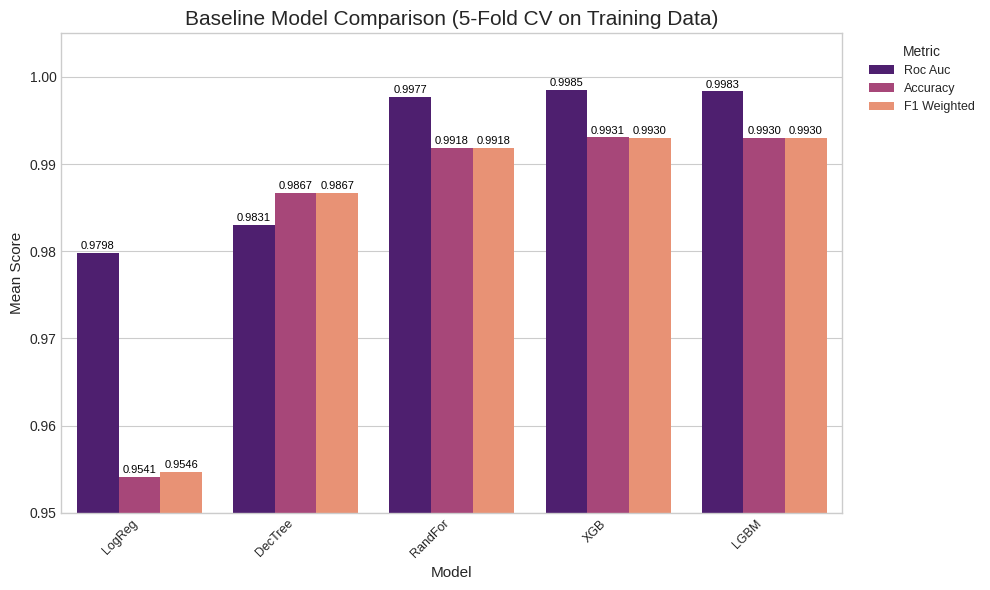


Baseline comparison finished in 626.77 seconds


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 5: Baseline Model Comparison
Evaluates standard classifiers using 5-fold stratified cross-validation.
"""

import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Optional: Check availability
xgb_available = 'xgb' in globals()
lgb_available = 'lgb' in globals()
scale_pos_weight = 1  # or your computed scale weight

print("\n--- 5. Baseline Model Comparison ---")
start_time_baseline = time.time()

models_baseline = {
    "LogReg": LogisticRegression(max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced'),
    "DecTree": DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced'),
    "RandFor": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
}
if xgb_available:
    models_baseline["XGB"] = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, scale_pos_weight=scale_pos_weight)
if lgb_available:
    models_baseline["LGBM"] = lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced', verbosity=-1)  # Suppress verbose output

results_cv_baseline = {}
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics_baseline = ['roc_auc', 'accuracy', 'f1_weighted']

for name, model_instance in models_baseline.items():
    print(f"\nEvaluating Baseline: {name}")
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', model_instance)])
    scores = {}
    try:
        for metric in scoring_metrics_baseline:
            # Ensure X_train and y_train are defined and suitable (e.g., numpy arrays or pandas DataFrames)
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_stratified, scoring=metric, n_jobs=-1)
            scores[f'{metric}_mean'] = cv_scores.mean()
            scores[f'{metric}_std'] = cv_scores.std()
            print(f"  Mean {metric}: {scores[f'{metric}_mean']:.4f} (+/- {scores[f'{metric}_std']:.4f})")
        results_cv_baseline[name] = scores
    except Exception as e:
        print(f"  Evaluation failed for {name}: {e}")
        # Fixed dictionary comprehension syntax
        results_cv_baseline[name] = {
            k: 0.0 for m in scoring_metrics_baseline for k in (f'{m}_mean', f'{m}_std')
        }

# --- Visualize Baseline CV Results ---
print("\n--- Baseline Model Performance Comparison (CV Means) ---")
if results_cv_baseline:
    results_cv_baseline_df = pd.DataFrame(results_cv_baseline).T.reset_index().rename(columns={'index': 'Model'})
    results_melted_baseline = pd.melt(
        results_cv_baseline_df,
        id_vars=['Model'],
        value_vars=[f'{m}_mean' for m in scoring_metrics_baseline],
        var_name='Metric',
        value_name='Score'
    )
    results_melted_baseline['Metric'] = results_melted_baseline['Metric'].str.replace('_mean', '').str.replace('_', ' ').str.title()

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted_baseline, palette='magma')
    plt.title('Baseline Model Comparison (5-Fold CV on Training Data)', fontsize=15)
    plt.ylabel('Mean Score', fontsize=11)
    plt.xlabel('Model', fontsize=11)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.ylim(0.95, 1.005)
    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.tight_layout()
    plt.show()
else:
    print("No baseline results to visualize.")

print(f"\nBaseline comparison finished in {time.time() - start_time_baseline:.2f} seconds")



--- 6. Feature Selection ---
Using RandomForest for feature importance...

--- Generating Feature Importance ---


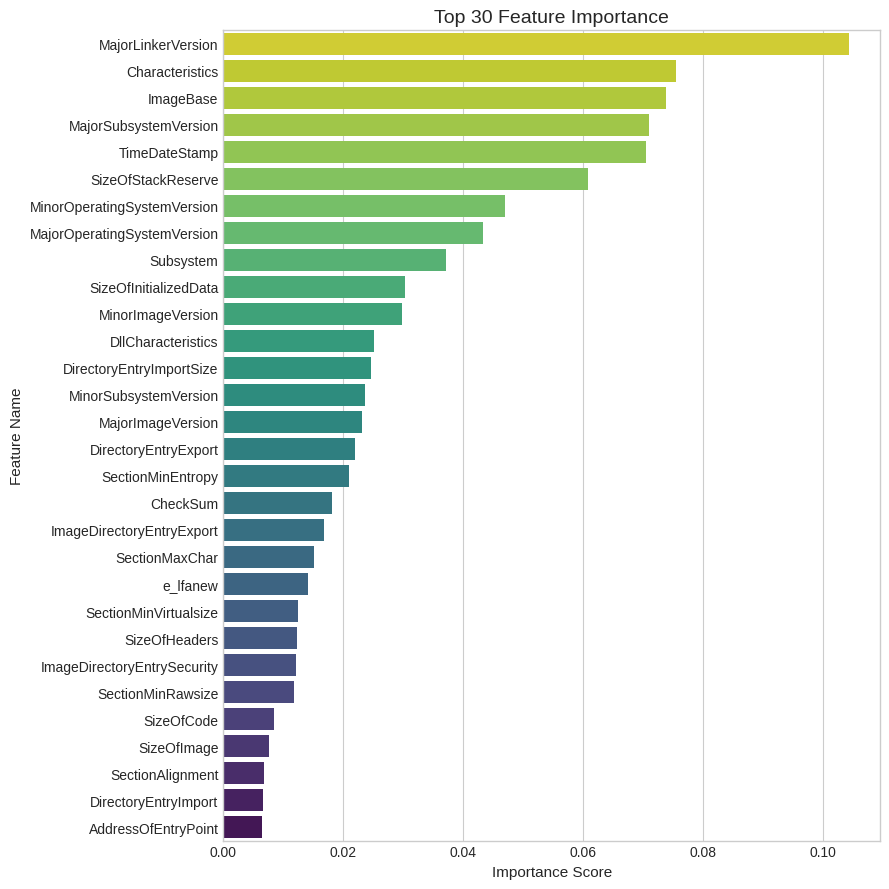


Selected 25 features with importance >= 0.01:
['MajorLinkerVersion', 'Characteristics', 'ImageBase', 'MajorSubsystemVersion', 'TimeDateStamp', 'SizeOfStackReserve', 'MinorOperatingSystemVersion', 'MajorOperatingSystemVersion', 'Subsystem', 'SizeOfInitializedData', 'MinorImageVersion', 'DllCharacteristics', 'DirectoryEntryImportSize', 'MinorSubsystemVersion', 'MajorImageVersion', 'DirectoryEntryExport', 'SectionMinEntropy', 'CheckSum', 'ImageDirectoryEntryExport', 'SectionMaxChar', 'e_lfanew', 'SectionMinVirtualsize', 'SizeOfHeaders', 'ImageDirectoryEntrySecurity', 'SectionMinRawsize']

Created important feature datasets with 25 features.
Feature selection finished in 1.32 seconds


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 6: Feature Selection
Identifies and selects important features using RandomForest.
"""
print("\n--- 6. Feature Selection ---")
start_time_fs = time.time()

feature_selector_model = None
importance_df = None # Initialize importance_df
if "RandFor" in models_baseline: # Check using short name used in baseline dict
    print("Using RandomForest for feature importance...")
    try:
        # Train RF specifically for feature selection (no scaling needed here)
        feature_selector_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
        feature_selector_model.fit(X_train, y_train) # Fit on original training data
        importance_df = plot_feature_importance(feature_selector_model, original_feature_names, top_n=30)
    except Exception as e:
         print(f" Error during feature selection model training/plotting: {e}")
         feature_selector_model = None # Ensure it's None if fit fails
else:
    print("RandomForest baseline not available for feature selection.")

important_features = original_feature_names # Default to all features

if importance_df is not None:
    importance_threshold = 0.01
    important_features_series = importance_df[importance_df['Importance'] >= importance_threshold]['Feature']
    if not important_features_series.empty:
        important_features = important_features_series.tolist()
        print(f"\nSelected {len(important_features)} features with importance >= {importance_threshold}:")
        print(important_features)
    else:
        print(f"No features met the importance threshold {importance_threshold}. Using all features.")
        important_features = original_feature_names # Revert to all if none selected
else:
    print("Could not perform feature selection based on importance. Using all features.")

# Create datasets with only important features
try:
    X_train_important = X_train[important_features]
    X_test_important = X_test[important_features]
    X_important = X[important_features] # Full dataset with important features
    print(f"\nCreated important feature datasets with {len(important_features)} features.")
except KeyError as e:
     print(f"Error creating important feature datasets. A selected feature might be missing: {e}")
     print("Falling back to using all features.")
     important_features = original_feature_names
     X_train_important = X_train
     X_test_important = X_test
     X_important = X

print(f"Feature selection finished in {time.time() - start_time_fs:.2f} seconds")

In [ ]:
# -*- coding: utf-8 -*-
"""
Block 7: Hyperparameter Tuning
Optimizes hyperparameters for the best baseline models using GridSearchCV.
"""
print("\n--- 7. Hyperparameter Tuning ---")
start_time_tuning = time.time()

models_to_tune = {}
tuning_threshold = 0.99
baseline_keys_map = {"LogReg": "LogisticRegression", "DecTree": "DecisionTree",
                     "RandFor": "RandomForest", "XGB": "XGBoost", "LGBM": "LightGBM"}

# Select models based on baseline results_cv_baseline dictionary
for short_name, metrics in results_cv_baseline.items():
    if metrics.get('roc_auc_mean', 0) >= tuning_threshold:
        full_name = baseline_keys_map.get(short_name)
        # Ensure the model instance exists in the original 'models_baseline' dict before adding
        if full_name and full_name in models_baseline:
            models_to_tune[short_name] = models_baseline[full_name]
        elif short_name in models_baseline: # If short name itself was the key
             models_to_tune[short_name] = models_baseline[short_name]


print(f"Models selected for tuning (ROC AUC >= {tuning_threshold}): {list(models_to_tune.keys())}")

# --- Parameter Grids (Refined & Shortened Names) ---
# Define grids only for models that might be tuned
param_grids = {}
if "RandFor" in models_to_tune:
    param_grids["RandFor"] = {
        'classifier__n_estimators': [200, 300], # Reduced for Kaggle speed
        'classifier__max_depth': [None, 30],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__class_weight': ['balanced', 'balanced_subsample'],
        'classifier__max_features': ['sqrt', 0.5],
        'classifier__bootstrap': [True]
    }
if "XGB" in models_to_tune:
     param_grids["XGB"] = {
        'classifier__n_estimators': [200, 300],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [5, 7],
        'classifier__subsample': [0.7, 0.8],
        'classifier__colsample_bytree': [0.7, 0.8],
        'classifier__gamma': [0.1, 0.2],
        'classifier__scale_pos_weight': [1, scale_pos_weight]
     }


best_estimators = {}
best_scores = {}

# --- Perform Grid Search ---
for name, model_instance in models_to_tune.items():
    print(f"\nTuning: {name}")
    if name not in param_grids:
        print(f"  Skipping {name}, parameter grid missing.")
        continue
    current_param_grid = param_grids[name]

    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', model_instance)])
    # Use fewer CV folds for faster tuning in Kaggle if needed (e.g., cv=3)
    grid_search = GridSearchCV(pipeline, current_param_grid, cv=3, # Reduced folds for speed
                               scoring='roc_auc', n_jobs=-1, verbose=1, error_score='raise')
    try:
        grid_search.fit(X_train_important, y_train) # Tune on important features
        best_estimators[name] = grid_search.best_estimator_
        best_scores[name] = grid_search.best_score_
        print(f"  Best Score (ROC AUC) for {name}: {grid_search.best_score_:.5f}")
        print(f"  Best Parameters for {name}: {grid_search.best_params_}")
    except Exception as e:
        print(f"  GridSearchCV failed for {name}: {e}")
        best_scores[name] = 0.0


# --- Select the Overall Best Model ---
final_model_pipeline = None
best_model_name = "None Selected"
if best_scores:
    successful_scores = {k: v for k, v in best_scores.items() if v > 0}
    if successful_scores:
        best_model_name = max(successful_scores, key=successful_scores.get)
        final_model_pipeline = best_estimators[best_model_name]
        print(f"\n--- Selected Best Model (based on ROC AUC): {best_model_name} ---")
        print(f"Best CV ROC AUC: {successful_scores[best_model_name]:.5f}")
        print("Best Estimator Pipeline:")
        print(final_model_pipeline)
    else:
        print("\n--- All models failed tuning. ---")

if final_model_pipeline is None:
    print("Falling back to the baseline RandomForest with scaling.")
    # Use short name consistent with baseline keys
    fallback_model_instance = models_baseline.get("RandFor", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))
    final_model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', fallback_model_instance)
    ])
    final_model_pipeline.fit(X_train_important, y_train)
    best_model_name = "RandFor_Baseline" # Use short name

print(f"\nHyperparameter tuning finished in {time.time() - start_time_tuning:.2f} seconds")


--- 7. Hyperparameter Tuning ---
Models selected for tuning (ROC AUC >= 0.99): ['RandFor', 'XGB', 'LGBM']

Tuning: RandFor
Fitting 3 folds for each of 64 candidates, totalling 192 fits
  Best Score (ROC AUC) for RandFor: 0.99791
  Best Parameters for RandFor: {'classifier__bootstrap': True, 'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}

Tuning: XGB
Fitting 3 folds for each of 128 candidates, totalling 384 fits
  Best Score (ROC AUC) for XGB: 0.99852
  Best Parameters for XGB: {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8}

Tuning: LGBM
  Skipping LGBM, parameter grid missing.

--- Selected Best Model (based on ROC AUC): XGB ---
Best CV ROC A


--- 8. Final Model Evaluation on Test Set ---

--- Evaluation Results for Model: XGB on Test Set ---

--- Generating Classification Metrics (XGB - Test Set) ---


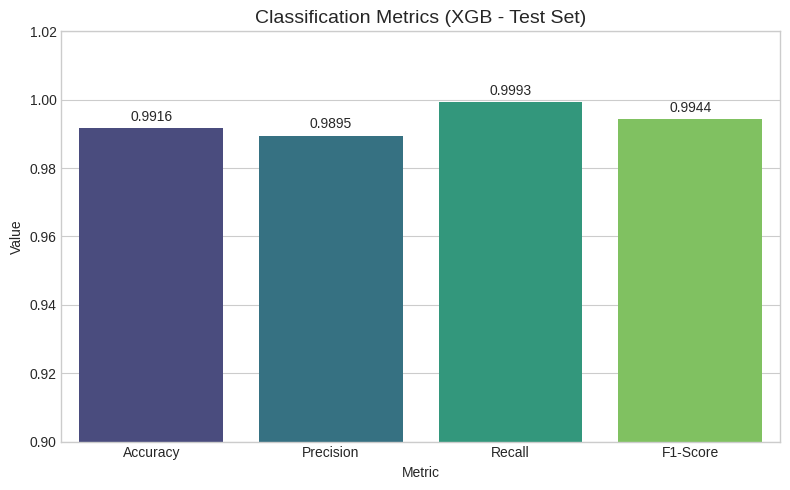


Classification Report (XGB - Test Set):
              precision    recall  f1-score   support

      Benign       1.00      0.97      0.98      1003
     Malware       0.99      1.00      0.99      2920

    accuracy                           0.99      3923
   macro avg       0.99      0.98      0.99      3923
weighted avg       0.99      0.99      0.99      3923



<Figure size 700x500 with 0 Axes>

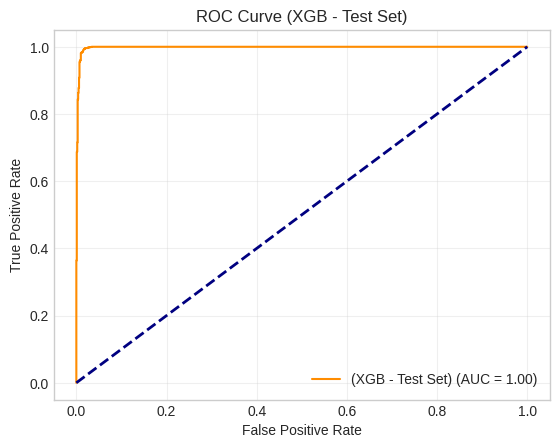

<Figure size 700x500 with 0 Axes>

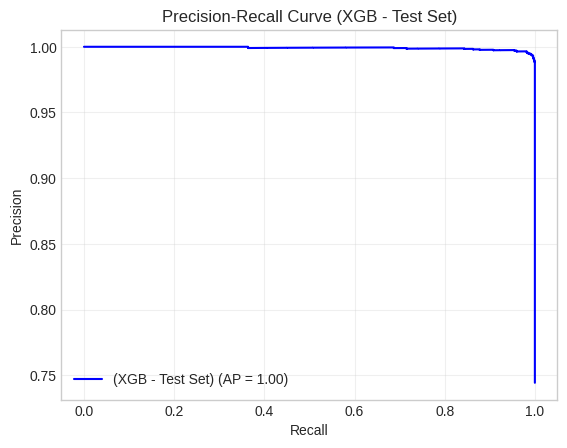


--- Generating Confusion Matrix (XGB - Test Set)  ---


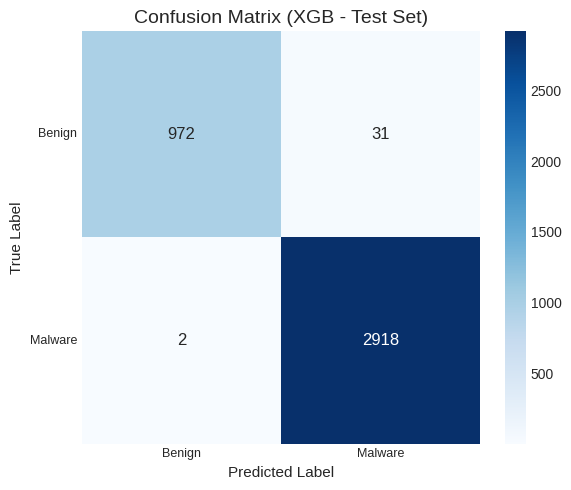


Confusion Matrix Breakdown:
  True Negatives (TN): 972 (24.78%)
  False Positives (FP): 31 (0.79%)
  False Negatives (FN): 2 (0.05%)
  True Positives (TP): 2918 (74.38%)

--- Generating Confusion Matrix (XGB - Test Set) (Normalized) ---


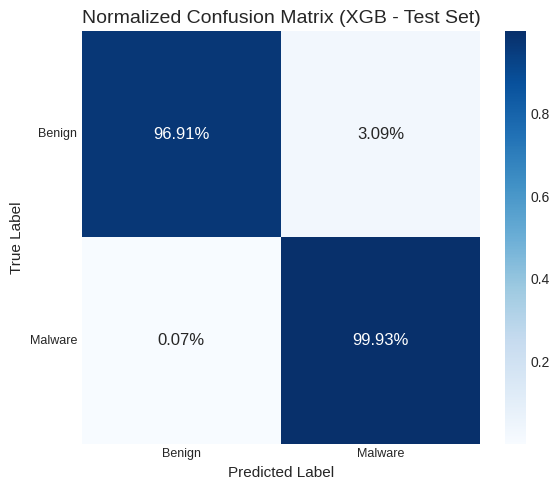


Test set evaluation finished in 0.95 seconds


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 8: Final Model Evaluation on Test Set
Evaluates the performance of the selected, tuned model on unseen test data.
"""
print("\n--- 8. Final Model Evaluation on Test Set ---")
start_time_eval = time.time()

if final_model_pipeline:
    y_pred_final = final_model_pipeline.predict(X_test_important)
    y_scores_final = None
    if hasattr(final_model_pipeline, 'predict_proba'):
        try: y_scores_final = final_model_pipeline.predict_proba(X_test_important)[:, 1]
        except Exception as e: print(f"Could not get predict_proba scores: {e}")
    elif hasattr(final_model_pipeline, 'decision_function'):
        try: y_scores_final = final_model_pipeline.decision_function(X_test_important)
        except Exception as e: print(f"Could not get decision_function scores: {e}")

    print(f"\n--- Evaluation Results for Model: {best_model_name} on Test Set ---")
    plot_classification_metrics(y_test, y_pred_final, y_scores_final, title_suffix=f"({best_model_name} - Test Set)")
    plot_confusion_matrix(y_test, y_pred_final, title_suffix=f"({best_model_name} - Test Set)", normalize=False)
    plot_confusion_matrix(y_test, y_pred_final, title_suffix=f"({best_model_name} - Test Set)", normalize=True)
else:
    print("Skipping test set evaluation as no final model was selected.")

print(f"\nTest set evaluation finished in {time.time() - start_time_eval:.2f} seconds")


--- 9. Model Explainability (SHAP) ---
Using SHAP TreeExplainer...


100%|===================| 15634/15688 [01:40<00:00]        

  TreeExplainer initialized with background data.

SHAP Summary Plot (dot - Global Impact):


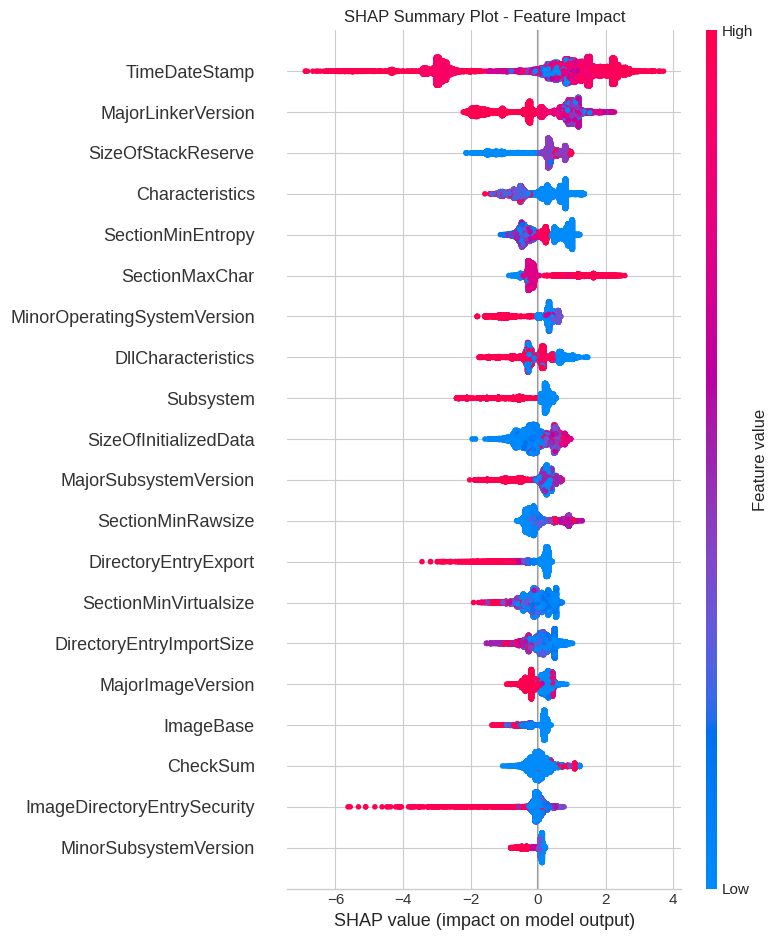


SHAP Summary Plot (bar - Global Importance):


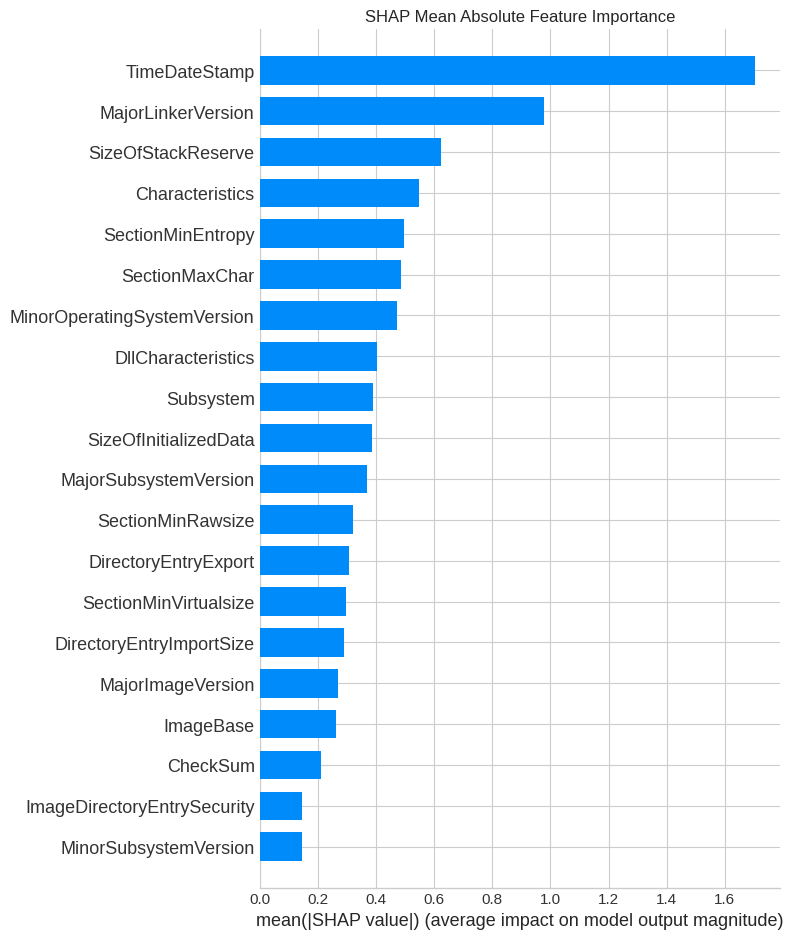


--- Local SHAP Explanations (Example Instances) ---


 99%|===================| 3891/3923 [00:25<00:00]        


SHAP Force Plot (Correct MALWARE, test index 0):



SHAP Force Plot (Correct BENIGN, test index 1):



SHAP Force Plot (MISCLASSIFIED (FN), test index 1219):



SHAP Force Plot (MISCLASSIFIED (FP), test index 190):



SHAP analysis finished in 128.37 seconds


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 9: Model Explainability (SHAP)
Uses SHAP library to explain global and local model predictions.
"""
print("\n--- 9. Model Explainability (SHAP) ---")
start_time_shap = time.time()

if shap_available and final_model_pipeline:
    final_classifier = final_model_pipeline.named_steps['classifier']
    scaler = final_model_pipeline.named_steps['scaler']

    # Prepare DataFrames with correct feature names for SHAP plots
    # Use the datasets containing only the important features
    X_train_important_df = pd.DataFrame(X_train_important, columns=important_features)
    X_test_important_df = pd.DataFrame(X_test_important, columns=important_features)

    # Scale data FOR SHAP explainer input
    X_train_important_scaled = scaler.transform(X_train_important_df)
    X_test_important_scaled = scaler.transform(X_test_important_df)
    X_train_important_scaled_df = pd.DataFrame(X_train_important_scaled, columns=important_features)
    X_test_important_scaled_df = pd.DataFrame(X_test_important_scaled, columns=important_features)


    explainer = None
    shap_values = None
    expected_value = None

    try:
        if isinstance(final_classifier, (RandomForestClassifier, xgb.XGBClassifier, lgb.LGBMClassifier)):
            print("Using SHAP TreeExplainer...")
            # Provide background data to TreeExplainer for potentially better results
            try:
                 explainer = shap.TreeExplainer(final_classifier, X_train_important_scaled_df)
                 shap_values = explainer.shap_values(X_train_important_scaled_df) # Explain on scaled training data
                 expected_value = explainer.expected_value
                 print("  TreeExplainer initialized with background data.")
            except Exception as tree_ex:
                 print(f"  TreeExplainer with background failed: {tree_ex}. Trying without...")
                 explainer = shap.TreeExplainer(final_classifier) # Fallback
                 shap_values = explainer.shap_values(X_train_important_scaled_df)
                 expected_value = explainer.expected_value
                 print("  TreeExplainer initialized without background data.")

        elif hasattr(final_classifier, 'predict_proba'):
             print("Using SHAP KernelExplainer (explaining on 100 training samples)...")
             def pipeline_predict_proba(data):
                # Ensure input is DataFrame with correct columns for the pipeline
                if isinstance(data, np.ndarray):
                    data_df = pd.DataFrame(data, columns=X_train_important_df.columns)
                else: # Assume it's already a compatible DataFrame
                     data_df = data
                return final_model_pipeline.predict_proba(data_df)

             # Sample background data (must be DataFrame for column names)
             background_data_df = shap.sample(X_train_important_df, 100)
             explainer = shap.KernelExplainer(pipeline_predict_proba, background_data_df)
             print("  Calculating SHAP values for subset of test data (KernelExplainer)...")
             # Explain on scaled test data subset
             shap_values = explainer.shap_values(X_test_important_scaled_df[:100])
             expected_value = explainer.expected_value
        else:
            print(f"SHAP explanation not directly supported for {type(final_classifier)}.")

        if explainer and shap_values is not None:
             # Handle SHAP value output structure for binary classification
             if isinstance(shap_values, list) and len(shap_values) == 2:
                 shap_values_for_plot = shap_values[1] # Use values for class 1 (Malware)
             elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3 and shap_values.shape[-1] == 2:
                  shap_values_for_plot = shap_values[:,:,1] # Use values for class 1
             else:
                 shap_values_for_plot = shap_values # Assume correct format otherwise

             # Handle expected_value structure
             if isinstance(expected_value, (list, np.ndarray)) and len(expected_value) == 2:
                  expected_value_for_plot = expected_value[1]
             else:
                  expected_value_for_plot = expected_value


             print("\nSHAP Summary Plot (dot - Global Impact):")
             # Pass original (unscaled) feature values for interpretability
             shap.summary_plot(shap_values_for_plot, X_train_important_df, plot_type="dot", show=False)
             plt.title("SHAP Summary Plot - Feature Impact")
             plt.tight_layout()
             plt.show()

             print("\nSHAP Summary Plot (bar - Global Importance):")
             shap.summary_plot(shap_values_for_plot, X_train_important_df, plot_type="bar", show=False)
             plt.title("SHAP Mean Absolute Feature Importance")
             plt.tight_layout()
             plt.show()

             # --- Local Explanation ---
             print("\n--- Local SHAP Explanations (Example Instances) ---")
             shap_values_test = None
             try:
                 if isinstance(explainer, shap.TreeExplainer):
                     shap_values_test = explainer.shap_values(X_test_important_scaled_df) # Explain full scaled test set
                     if isinstance(shap_values_test, list): shap_values_test = shap_values_test[1]
                     elif isinstance(shap_values_test, np.ndarray) and shap_values_test.ndim == 3: shap_values_test = shap_values_test[:,:,1]
                 elif isinstance(explainer, shap.KernelExplainer):
                     # We only calculated for a subset earlier for global plot
                     # For local, we need values for specific indices
                     print("Calculating SHAP values for specific test instances (KernelExplainer)...")
                     indices_to_explain_local = []
                     malware_indices_local = np.where((y_test.values == 1) & (y_pred_final == 1))[0]
                     benign_indices_local = np.where((y_test.values == 0) & (y_pred_final == 0))[0]
                     fn_indices_local = np.where((y_test.values == 1) & (y_pred_final == 0))[0]
                     fp_indices_local = np.where((y_test.values == 0) & (y_pred_final == 1))[0]

                     if len(malware_indices_local)>0: indices_to_explain_local.append(malware_indices_local[0])
                     if len(benign_indices_local)>0: indices_to_explain_local.append(benign_indices_local[0])
                     if len(fn_indices_local)>0: indices_to_explain_local.append(fn_indices_local[0])
                     if len(fp_indices_local)>0: indices_to_explain_local.append(fp_indices_local[0])

                     if indices_to_explain_local:
                          shap_values_test_instances = explainer.shap_values(X_test_important_scaled_df.iloc[indices_to_explain_local])
                          if isinstance(shap_values_test_instances, list): shap_values_test_instances = shap_values_test_instances[1]
                          # Create a placeholder array for consistency if needed, mapping calculated values
                          shap_values_test = np.zeros((X_test_important_scaled_df.shape[0], X_test_important_scaled_df.shape[1])) # Placeholder
                          for i, original_idx in enumerate(indices_to_explain_local):
                               shap_values_test[original_idx] = shap_values_test_instances[i]
                     else:
                          print("No specific instances found for local explanation examples.")
                          shap_values_test = None

                 if shap_values_test is not None:
                      # Define instance types to explain
                      explanation_cases = {
                           "Correct MALWARE": np.where((y_test.values == 1) & (y_pred_final == 1))[0],
                           "Correct BENIGN": np.where((y_test.values == 0) & (y_pred_final == 0))[0],
                           "MISCLASSIFIED (FN)": np.where((y_test.values == 1) & (y_pred_final == 0))[0],
                           "MISCLASSIFIED (FP)": np.where((y_test.values == 0) & (y_pred_final == 1))[0]
                      }

                      for case_name, indices in explanation_cases.items():
                           if len(indices) > 0:
                                idx = indices[0] # Explain the first instance of this type
                                print(f"\nSHAP Force Plot ({case_name}, test index {idx}):")
                                # Pass original (unscaled) feature values for the instance data display
                                display(shap.force_plot(expected_value_for_plot,
                                                 shap_values_test[idx],
                                                 X_test_important_df.iloc[idx], # Pass DataFrame slice
                                                 matplotlib=False))
                           else:
                                print(f"\nNo instances found for case: {case_name}")
                 else:
                      print("Could not calculate SHAP values for test instances.")

             except Exception as e_local:
                 print(f"Error generating local SHAP explanations: {e_local}")
    except Exception as e_shap:
        print(f"Error during SHAP explanation: {e_shap}")

elif not shap_available:
    print("\nSkipping SHAP explanations: 'shap' library not installed.")
else:
    print("\nSkipping SHAP explanations: no final model.")

print(f"\nSHAP analysis finished in {time.time() - start_time_shap:.2f} seconds")


--- 10. Final Cross-Validation & Learning Curves ---

--- Cross-Validation on Final Tuned Model (Full Dataset with Important Features) ---

--- Performing StratifiedKFold(n_splits=5, random_state=42, shuffle=True)-Fold Cross-Validation (roc_auc) (Final Model - Full Data) ---
  CV finished in 3.16 seconds.
  CV Scores (roc_auc): ['0.9995', '0.9990', '0.9989', '0.9984', '0.9985']
  Mean CV Score (roc_auc): 0.9989
  Std Dev (roc_auc): 0.0004


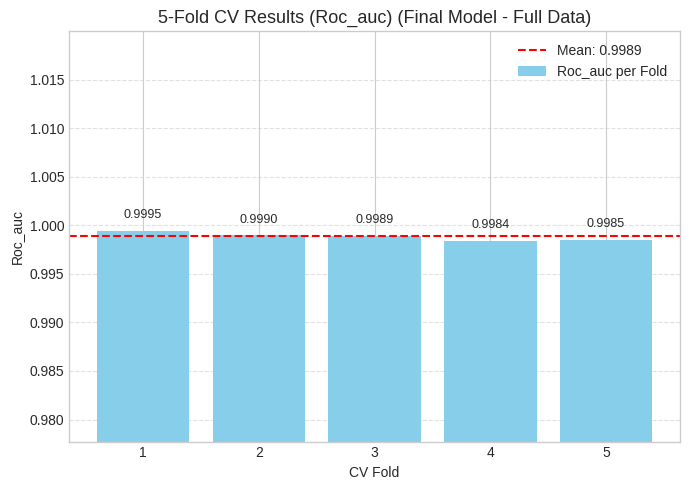


--- Performing StratifiedKFold(n_splits=5, random_state=42, shuffle=True)-Fold Cross-Validation (accuracy) (Final Model - Full Data) ---
  CV finished in 1.46 seconds.
  CV Scores (accuracy): ['0.9944', '0.9936', '0.9924', '0.9916', '0.9936']
  Mean CV Score (accuracy): 0.9931
  Std Dev (accuracy): 0.0010


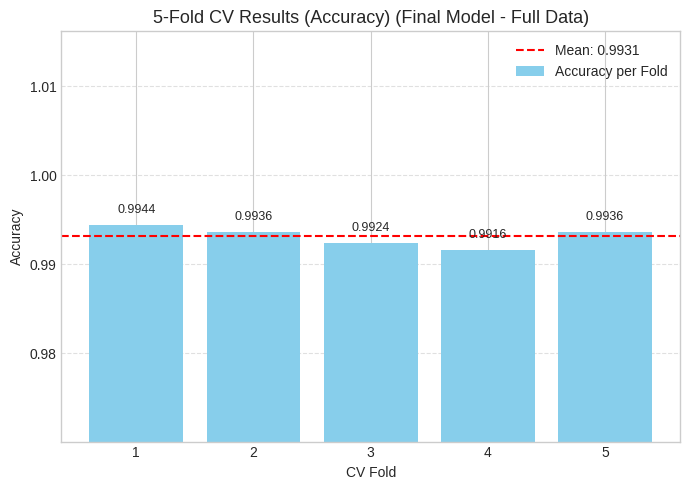


--- Performing StratifiedKFold(n_splits=5, random_state=42, shuffle=True)-Fold Cross-Validation (f1_weighted) (Final Model - Full Data) ---
  CV finished in 1.44 seconds.
  CV Scores (f1_weighted): ['0.9944', '0.9936', '0.9923', '0.9916', '0.9936']
  Mean CV Score (f1_weighted): 0.9931
  Std Dev (f1_weighted): 0.0010


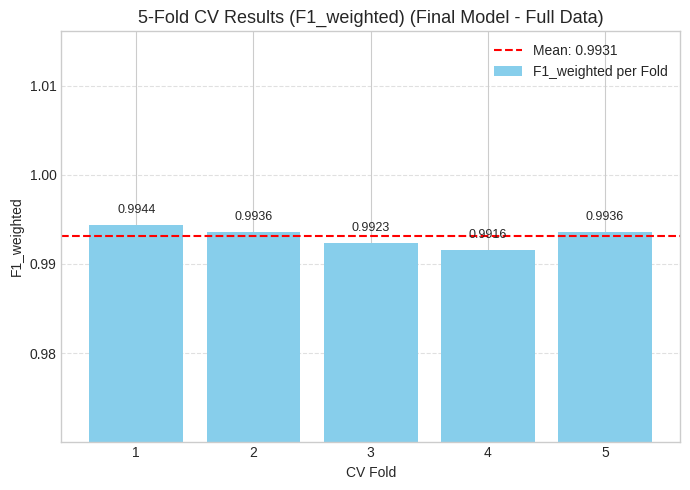


--- Performing StratifiedKFold(n_splits=5, random_state=42, shuffle=True)-Fold Cross-Validation (precision_weighted) (Final Model - Full Data) ---
  CV finished in 1.44 seconds.
  CV Scores (precision_weighted): ['0.9944', '0.9936', '0.9924', '0.9916', '0.9937']
  Mean CV Score (precision_weighted): 0.9931
  Std Dev (precision_weighted): 0.0010


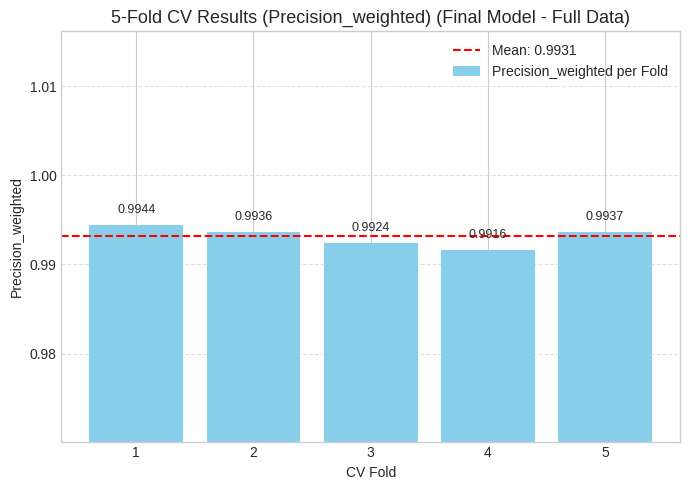


--- Performing StratifiedKFold(n_splits=5, random_state=42, shuffle=True)-Fold Cross-Validation (recall_weighted) (Final Model - Full Data) ---
  CV finished in 1.53 seconds.
  CV Scores (recall_weighted): ['0.9944', '0.9936', '0.9924', '0.9916', '0.9936']
  Mean CV Score (recall_weighted): 0.9931
  Std Dev (recall_weighted): 0.0010


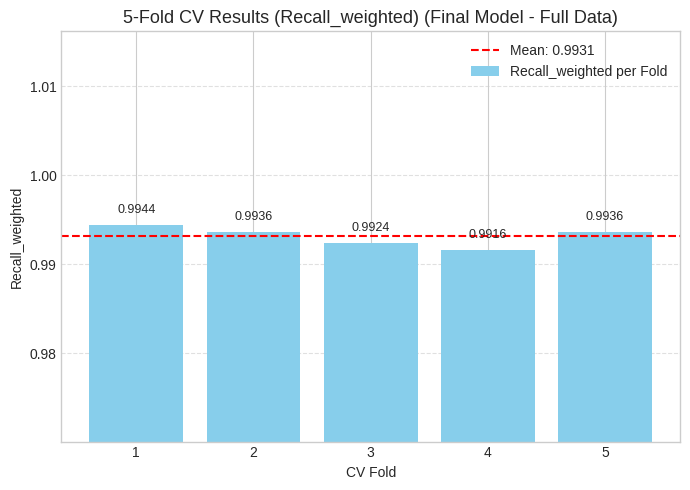


--- Learning Curves for Final Tuned Model (Full Dataset with Important Features) ---


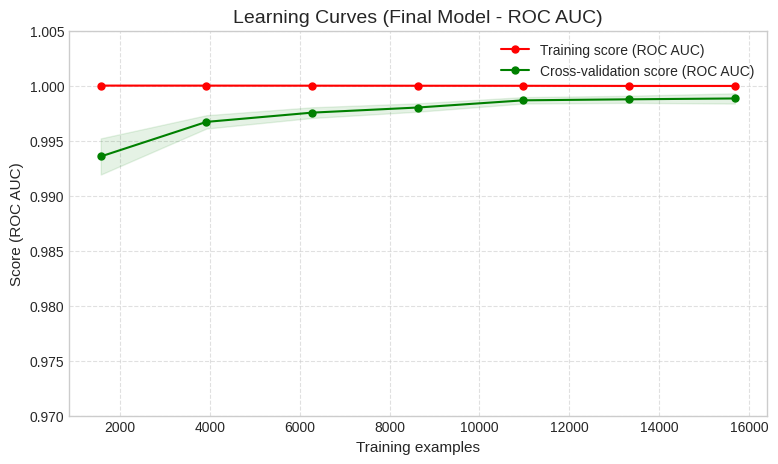


Final CV & Learning Curves finished in 15.97 seconds


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 10: Final Cross-Validation & Learning Curves
Validates the final tuned model's robustness on the full dataset.
"""
print("\n--- 10. Final Cross-Validation & Learning Curves ---")
start_time_final_cv = time.time()

if final_model_pipeline:
    print("\n--- Cross-Validation on Final Tuned Model (Full Dataset with Important Features) ---")
    cv_metrics = ['roc_auc', 'accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
    cv_results_final = {}
    for metric in cv_metrics:
        scores = plot_cross_validation(final_model_pipeline, X_important, y, cv=cv_stratified, scoring=metric, title_suffix="(Final Model - Full Data)")
        if scores is not None:
            cv_results_final[metric] = {'mean': scores.mean(), 'std': scores.std(), 'scores': scores.tolist()}

    # --- Learning Curves ---
    print("\n--- Learning Curves for Final Tuned Model (Full Dataset with Important Features) ---")
    try:
        # Use roc_auc for learning curve scoring as it's often preferred for classification
        train_sizes_abs, train_scores_lc, val_scores_lc = learning_curve(
            final_model_pipeline, X_important, y, cv=cv_stratified, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 7), scoring='roc_auc', shuffle=True, random_state=42
        )
        train_scores_mean_lc = np.mean(train_scores_lc, axis=1)
        train_scores_std_lc = np.std(train_scores_lc, axis=1)
        val_scores_mean_lc = np.mean(val_scores_lc, axis=1)
        val_scores_std_lc = np.std(val_scores_lc, axis=1)

        plt.figure(figsize=(9, 5)) # Adjusted size
        plt.plot(train_sizes_abs, train_scores_mean_lc, 'o-', color="r", markersize=5, label="Training score (ROC AUC)")
        plt.fill_between(train_sizes_abs, train_scores_mean_lc - train_scores_std_lc, train_scores_mean_lc + train_scores_std_lc, alpha=0.1, color="r")
        plt.plot(train_sizes_abs, val_scores_mean_lc, 'o-', color="g", markersize=5, label="Cross-validation score (ROC AUC)")
        plt.fill_between(train_sizes_abs, val_scores_mean_lc - val_scores_std_lc, val_scores_mean_lc + val_scores_std_lc, alpha=0.1, color="g")
        plt.title('Learning Curves (Final Model - ROC AUC)', fontsize=14)
        plt.xlabel('Training examples', fontsize=11)
        plt.ylabel('Score (ROC AUC)', fontsize=11)
        plt.legend(loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(0.97, 1.005) # Fine-tune ylim based on observed scores
        plt.show()

    except Exception as e:
        print(f"Error generating learning curves: {e}")
else:
    print("\nSkipping final CV and learning curves.")

print(f"\nFinal CV & Learning Curves finished in {time.time() - start_time_final_cv:.2f} seconds")

In [ ]:
# -*- coding: utf-8 -*-
"""
Block 11: Save Final Model & Features
Persists the trained pipeline and selected feature list to the Kaggle output directory.
"""
print("\n--- 11. Save Final Model and Selected Features ---")

if 'final_model_pipeline' in locals() and final_model_pipeline:
    final_model_path = os.path.join(model_output_dir, 'malwareclassifier_final_pipeline.pkl')
    features_path = os.path.join(model_output_dir, 'selected_features.json')

    try:
        joblib.dump(final_model_pipeline, final_model_path)
        print(f"Final model pipeline saved successfully to: {final_model_path}")
    except Exception as e:
        print(f"Error saving model pipeline: {e}")

    try:
        # Ensure important_features is defined and is a list
        if 'important_features' in locals() and isinstance(important_features, list):
            with open(features_path, 'w') as f:
                json.dump(important_features, f, indent=4)
            print(f"List of selected features saved successfully to: {features_path}")
        else:
             print("Error: 'important_features' list not found or invalid. Cannot save feature list.")
    except Exception as e:
        print(f"Error saving feature list: {e}")
else:
    print("No final model pipeline was created or selected, skipping save.")


--- 11. Save Final Model and Selected Features ---
Final model pipeline saved successfully to: /kaggle/working/ML_model_final/malwareclassifier_final_pipeline.pkl
List of selected features saved successfully to: /kaggle/working/ML_model_final/selected_features.json


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 12: Prediction Function Definition
Defines the function to predict malware for a *NEW* file using the saved artifacts.
NOTE: This function relies on the external `extract_features` which requires `pefile`.
It will likely FAIL in a standard Kaggle notebook *if called* unless pefile is
correctly installed AND the input `file_path` points to a local, accessible PE file.
Its main purpose here is to show how prediction *would* work outside the notebook.
"""
print("\n--- 12. Defining Prediction Function (for NEW files, requires pefile) ---")

def predict_malware_for_file(file_path,
                             model_dir='/kaggle/working/ML_model_final/',
                             model_filename='malwareclassifier_final_pipeline.pkl',
                             features_filename='selected_features.json'):
    """
    Predicts whether a file is malicious using saved model and feature list.
    REQUIRES PEFILE and the ability to read the file_path.
    """
    model_path = os.path.join(model_dir, model_filename)
    features_path = os.path.join(model_dir, features_filename)
    print(f"\n--- Predicting File: {os.path.basename(file_path)} ---")

    if not pefile_available:
        print("Error: 'pefile' library not available. Cannot extract features from raw file.")
        return {"error": "pefile library missing", "status": "error_dependency"}
    if not os.path.exists(file_path):
        print(f"Error: Input file not found: {file_path}")
        return {"error": "File not found", "status": "error"}

    # Load artifacts
    try:
        if not os.path.exists(model_path): raise FileNotFoundError(f"Model file not found: {model_path}")
        if not os.path.exists(features_path): raise FileNotFoundError(f"Features file not found: {features_path}")
        classifier_pipeline = joblib.load(model_path)
        with open(features_path, 'r') as f: selected_feature_names = json.load(f)
        print(f"Loaded model and {len(selected_feature_names)} features.")
    except Exception as e:
        print(f"Error loading model/features: {e}")
        return {"error": f"Load failed: {str(e)}", "status": "error"}

    # Extract features using the defined function
    try:
        features_df_raw = extract_features(file_path) # This requires pefile
        if features_df_raw is None or features_df_raw.empty:
            return {"error": "Feature extraction failed (maybe not PE)", "is_malware": None, "confidence": None, "status": "error_feature_extraction"}
    except Exception as e:
        print(f"Error in feature extraction call: {e}")
        return {"error": f"Feature extraction exception: {str(e)}", "status": "error_feature_extraction"}

    # Align features
    try:
        if features_df_raw.shape[0] != 1: raise ValueError(f"Expected 1 row, got {features_df_raw.shape[0]}")
        features_df_aligned = pd.DataFrame(0, index=[0], columns=selected_feature_names)
        common_cols = features_df_raw.columns.intersection(selected_feature_names)
        features_df_aligned[common_cols] = features_df_raw[common_cols].values
    except Exception as e:
        print(f"Error aligning features: {e}")
        return {"error": f"Feature alignment failed: {str(e)}", "status": "error"}

    # Make prediction
    try:
        prediction = classifier_pipeline.predict(features_df_aligned)[0]
        confidence = None
        if hasattr(classifier_pipeline, 'predict_proba'):
            probabilities = classifier_pipeline.predict_proba(features_df_aligned)[0]
            confidence = probabilities[prediction]

        result = {
            "file_name": os.path.basename(file_path),
            "prediction": int(prediction),
            "is_malware": bool(prediction == 1),
            "confidence": float(confidence) if confidence is not None else None,
            "status": "success"
        }
        pred_label = 'MALWARE' if result['is_malware'] else 'BENIGN'
        conf_str = f"(Confidence: {result['confidence']:.2%})" if result['confidence'] is not None else ""
        print(f"Prediction: {pred_label} {conf_str}")
        return result
    except Exception as e:
        print(f"Error making prediction: {e}")
        return {"error": f"Prediction failed: {str(e)}", "status": "error"}

print("Prediction function defined (requires pefile for new files).")


--- 12. Defining Prediction Function (for NEW files, requires pefile) ---
Prediction function defined (requires pefile for new files).


In [ ]:
# -*- coding: utf-8 -*-
"""
Block 13: Example Prediction (Demonstration Only)
Uses data ALREADY IN THE TEST CSV for prediction, as we cannot easily
extract features from raw files without pefile/local access in Kaggle.
"""
print("\n--- 13. Example Prediction (Using pre-extracted test data) ---")

if 'final_model_pipeline' in locals() and final_model_pipeline and 'X_test_important' in locals() and not X_test_important.empty:
    print("Predicting the first instance from the prepared *test set* features...")
    try:
        # Take the first row of the already processed important features test set
        instance_to_predict = X_test_important.iloc[[0]] # Keep it as a DataFrame

        prediction = final_model_pipeline.predict(instance_to_predict)[0]
        confidence = None
        if hasattr(final_model_pipeline, 'predict_proba'):
            probabilities = final_model_pipeline.predict_proba(instance_to_predict)[0]
            confidence = probabilities[prediction]

        result = {
            "source": "First instance from test set CSV (pre-extracted features)",
            "prediction": int(prediction),
            "is_malware": bool(prediction == 1),
            "confidence": float(confidence) if confidence is not None else None,
            "status": "success"
        }
        pred_label = 'MALWARE' if result['is_malware'] else 'BENIGN'
        conf_str = f"(Confidence: {result['confidence']:.2%})" if result['confidence'] is not None else ""
        print(f"Prediction: {pred_label} {conf_str}")
        print("\n--- Example Prediction Output ---")
        print(json.dumps(result, indent=4))

    except Exception as e:
        print(f"Error during example prediction using test data: {e}")
else:
    print("Skipping example prediction using test data: Final model or test data not available.")


print("\n--- Notebook Execution Complete ---")


--- 13. Example Prediction (Using pre-extracted test data) ---
Predicting the first instance from the prepared *test set* features...
Prediction: MALWARE (Confidence: 99.83%)

--- Example Prediction Output ---
{
    "source": "First instance from test set CSV (pre-extracted features)",
    "prediction": 1,
    "is_malware": true,
    "confidence": 0.9983137845993042,
    "status": "success"
}

--- Notebook Execution Complete ---
